In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
print('Python version: ', sys.version)

Python version:  3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 18:53:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar # check if a date is holiday

plt.rcParams['figure.figsize'] = (16, 7)

# Loading cleaned turnstile data

In [4]:
def load_diff_data(filename):
    diff = pd.read_csv(filename, low_memory=False)
    diff['LINENAME'] =  diff['LINENAME'].astype(str)
    # parse datetime
    diff['datetime'] = pd.to_datetime(diff.datetime)
    diff['date'] = diff.datetime.dt.date
    diff['time'] = diff.datetime.dt.time
    # align years
    diff['month'] = diff.datetime.dt.month
    diff['day'] = diff.datetime.dt.day
    diff['dayofweek'] = diff.datetime.dt.weekday
    # check holiday
    cal = calendar()
    holidays = cal.holidays(diff['date'].min(),diff['date'].max())
    print('holidays:\n', holidays)
    diff['isholiday'] = diff['datetime'].dt.date.astype('datetime64').isin(holidays)
    return diff
diff_test = load_diff_data('../data/turnstile/turnstile_diffs_test.csv.zip')
diff_test.head()

holidays:
 DatetimeIndex([], dtype='datetime64[ns]', freq=None)


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,datetime,entries,exits,date,time,month,day,dayofweek,isholiday
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-04-04 00:00:00,-0.0,-0.0,2020-04-04,00:00:00,4,4,5,False
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-04-04 04:00:00,4.0,8.0,2020-04-04,04:00:00,4,4,5,False
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-04-04 08:00:00,10.0,9.0,2020-04-04,08:00:00,4,4,5,False
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-04-04 12:00:00,20.0,9.0,2020-04-04,12:00:00,4,4,5,False
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-04-04 16:00:00,26.0,5.0,2020-04-04,16:00:00,4,4,5,False


In [5]:
%%time
diff20 = load_diff_data('../data/turnstile/turnstile_diffs_2020.csv.zip')
diff19 = load_diff_data('../data/turnstile/turnstile_diffs_2019.csv.zip')

holidays:
 DatetimeIndex(['2020-01-01', '2020-01-20', '2020-02-17'], dtype='datetime64[ns]', freq=None)
holidays:
 DatetimeIndex(['2019-01-01', '2019-01-21', '2019-02-18', '2019-05-27'], dtype='datetime64[ns]', freq=None)
CPU times: user 16.6 s, sys: 2.08 s, total: 18.7 s
Wall time: 18.7 s


# 1. Overall change
## Total turnstile entries and exits in 2019 and 2020 

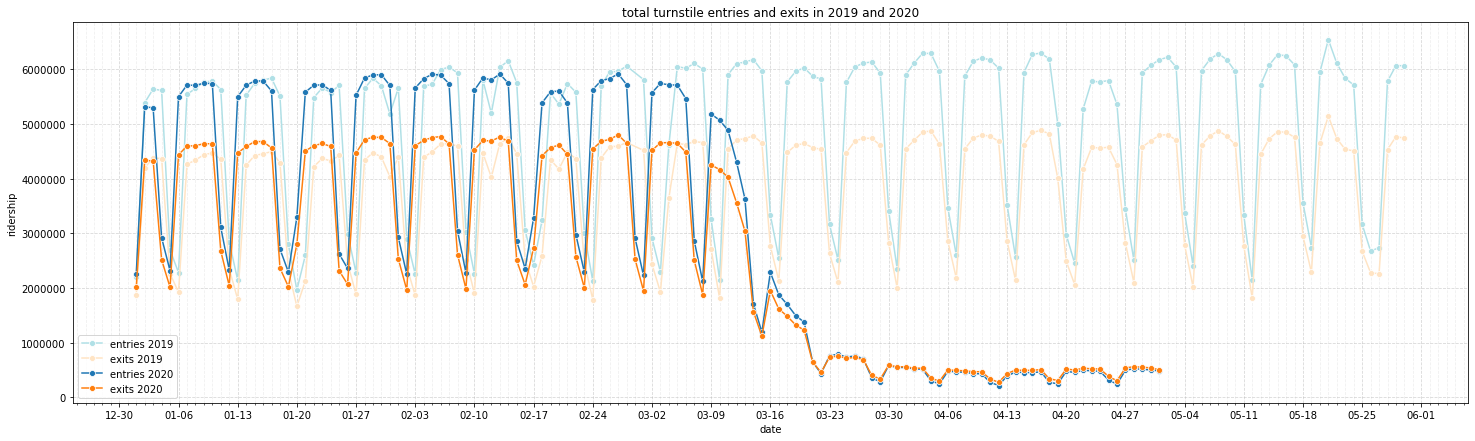

In [8]:
def plot_total(df19, df20):
    total19 = df19.groupby('date', as_index=False).agg({'entries':'sum', 'exits':'sum'})
    total20 = df20.groupby('date', as_index=False).agg({'entries':'sum', 'exits':'sum'})
    

    total19 = total19.loc[total19['date'] <= pd.to_datetime('2019-05-30')]
    total19['date'] = np.where(total19['date'] <= pd.to_datetime('2019-02-28'),
        total19['date'] + pd.Timedelta(days=365), total19['date'] + pd.Timedelta(days=366))
    
    fig, ax = plt.subplots(figsize=(25, 7))
    sns.lineplot(ax=ax, x="date", y='entries', data=total19, marker='o', color='powderblue', label='entries 2019')
    sns.lineplot(ax=ax, x="date", y='exits', data=total19, marker='o', color='bisque', label='exits 2019')
    sns.lineplot(ax=ax, x="date", y='entries', data=total20, marker='o', color='#1f77b4', label='entries 2020')
    sns.lineplot(ax=ax, x="date", y='exits', data=total20, marker='o', color='#ff7f0e', label='exits 2020')
    ax.legend(loc='lower left')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO)) #tick on monday
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.grid(linestyle='--',alpha=0.5, which='major')
    ax.grid(linestyle='--',alpha=0.2, which='minor')
    #plt.xticks(rotation=60)
    ax.set_ylabel('ridership')
    plt.title('total turnstile entries and exits in 2019 and 2020')
    plt.show()

plot_total(diff19 ,diff20)

## Overall subway mobility change
- How much did ridership change compared to previous months and year?
- How do policies affect the trend?

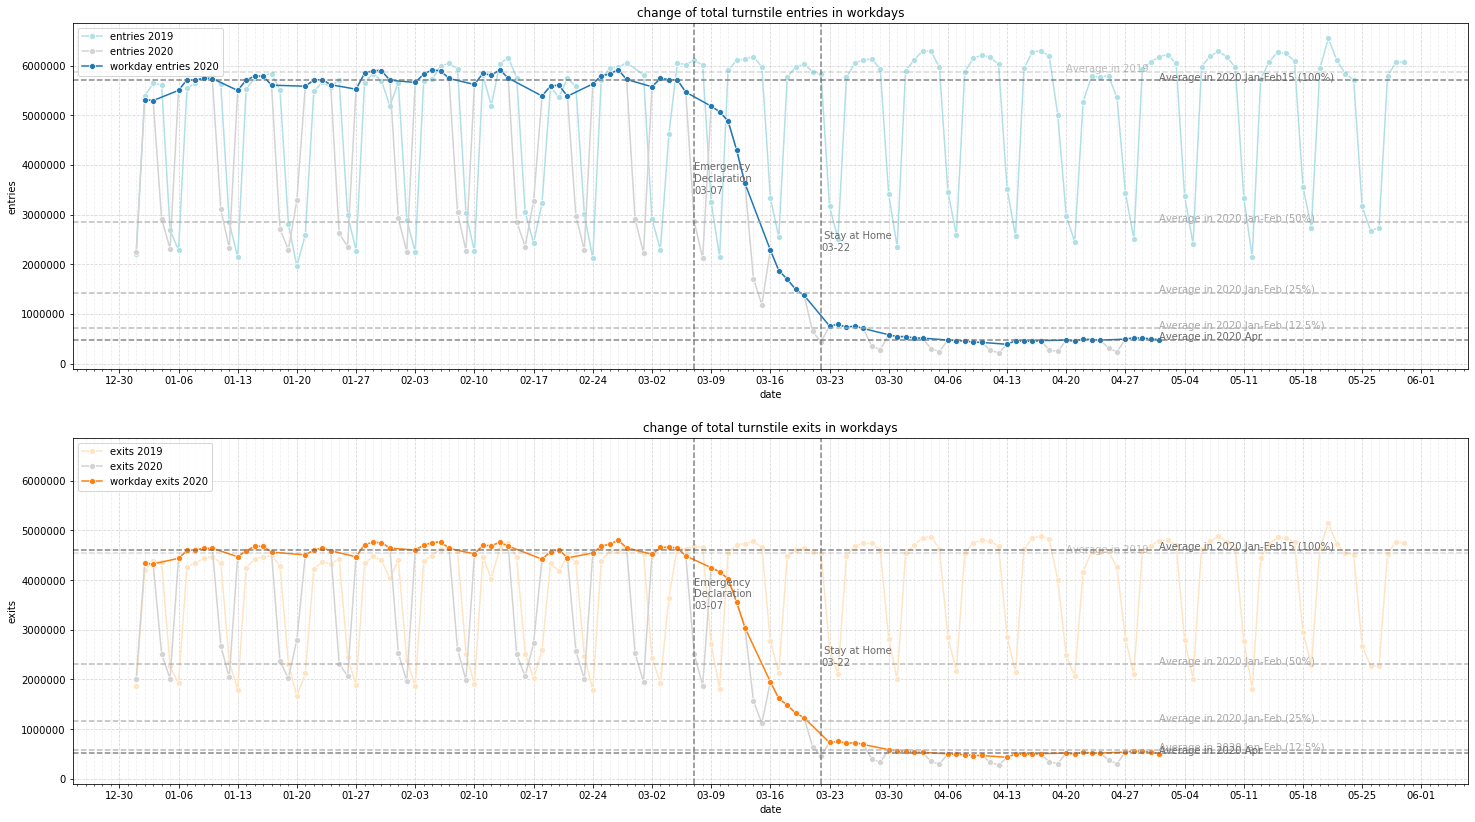

In [7]:
def process_daily_total(df):
    total = df.groupby(['date', 'dayofweek', 'isholiday'], as_index=False).agg({'entries':'sum', 'exits':'sum'})
    total['isweekday'] = (total['dayofweek'] < 5) & (total['isholiday'] == False)
    avg_weekday_ent = total.loc[total['isweekday']]['entries'].mean()
    avg_weekday_exi = total.loc[total['isweekday']]['exits'].mean()
    return total, [avg_weekday_ent, avg_weekday_exi]

def plot_total_weekday_change(df19, df20):
    # total
    total19,avg19 = process_daily_total(df19.loc[df19['date'] <= pd.to_datetime('2019-05-30')])
    total20,_ = process_daily_total(df20)
    # remove holidays
    total20_wk = total20.loc[total20['isweekday']]
    # 2020 before march
    _, avg20_jan = process_daily_total(df20.loc[df20['date'] <= pd.to_datetime('2020-02-15')])
    _, avg20_apr = process_daily_total(df20.loc[(df20['date'] >= pd.to_datetime('2020-04-01'))
                                                & (df20['date'] < pd.to_datetime('2020-05-01'))])
    # align 2019
    total19['date'] = np.where(total19['date'] <= pd.to_datetime('2019-02-28'),
        total19['date'] + pd.Timedelta(days=365), total19['date'] + pd.Timedelta(days=366))

    fig, axs = plt.subplots(nrows=2, figsize=(25, 14))
    sns.lineplot(ax=axs[0], x="date", y='entries', data=total19, marker='o', color='powderblue', label='entries 2019')
    sns.lineplot(ax=axs[0], x="date", y='entries', data=total20, marker='o', color='lightgrey', label='entries 2020')
    sns.lineplot(ax=axs[0], x="date", y='entries', data=total20_wk, marker='o', color='#1f77b4', label='workday entries 2020')
    sns.lineplot(ax=axs[1], x="date", y='exits', data=total19, marker='o', color='bisque', label='exits 2019')
    sns.lineplot(ax=axs[1], x="date", y='exits', data=total20, marker='o', color='lightgrey', label='exits 2020')
    sns.lineplot(ax=axs[1], x="date", y='exits', data=total20_wk, marker='o', color='#ff7f0e', label='workday exits 2020')
    # ticks and grid style
    for ax in axs:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO))
        ax.xaxis.set_minor_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.grid(linestyle='--',alpha=0.5, which='major')
        ax.grid(linestyle='--',alpha=0.2, which='minor')
        ax.legend(loc='upper left')
    # same y scale in both plots
    ylim = axs[0].get_ylim()
    axs[1].set_ylim(ylim[0], ylim[1])
    # annotations
    for i, ax in enumerate(axs):
        # 2019 Jan-May
        axs[i].axhline(y=avg19[i], linestyle='dashed', color='grey', alpha=0.3)
        axs[i].text(y=avg19[i], x=dt.datetime(2020,4,20), s='Average in 2019', color='grey', alpha=0.5)
        # 2020 Jan-Feb15
        axs[i].axhline(y=avg20_jan[i], linestyle='dashed', color='dimgray', alpha=0.8)
        axs[i].text(y=avg20_jan[i], x=dt.datetime(2020,5,1), s='Average in 2020 Jan-Feb15 (100%)', color='dimgray')
        # 2020 Jan-Feb 50%, 25%, 12.5%
        for r,text in [(0.5, '50%'), (0.25, '25%'), (0.125, '12.5%')]:
            axs[i].axhline(y=avg20_jan[i]*r, linestyle='dashed', color='darkgrey', alpha=0.8)
            axs[i].text(y=avg20_jan[i]*r, x=dt.datetime(2020,5,1),
                s='Average in 2020 Jan-Feb ('+text+')', color='darkgrey')
        # 2020 April
        axs[i].axhline(y=avg20_apr[i], linestyle='dashed', color='dimgray', alpha=0.8)
        axs[i].text(y=avg20_apr[i], x=dt.datetime(2020,5,1), s='Average in 2020 Apr', color='dimgray')
        # dates
        # 3-7 emergency declaration
        axs[i].axvline(x=dt.datetime(2020,3,7), linestyle='dashed', color='dimgray', alpha=0.8)
        axs[i].text(x=dt.datetime(2020,3,7), y=ylim[1]/2, s='Emergency\nDeclaration\n03-07', color='dimgray')
        # 3-22 stay at home
        axs[i].axvline(x=dt.datetime(2020,3,22), linestyle='dashed', color='dimgray', alpha=0.8)
        axs[i].text(x=dt.datetime(2020,3,22), y=ylim[1]/3, s=' Stay at Home\n03-22', color='dimgray')
    axs[0].title.set_text('change of total turnstile entries in workdays')
    axs[1].title.set_text('change of total turnstile exits in workdays')
    plt.show()

process_daily_total(diff19)
plot_total_weekday_change(diff19 ,diff20)

# 2. Mobility change by stations